In [1]:
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# Meta data of papers
class PaperMeta(object):
    def __init__(self, title, abstract, keyword, rating, url, withdrawn):
        self.title = title  # str
        self.abstract = abstract  # str
        self.keyword = keyword  # list[str]
        self.rating = rating  # list[int]
        self.url = url
        self.withdrawn = withdrawn
        
        if len(self.rating) > 0:
            self.average_rating = np.mean(rating)
        else:
            self.average_rating = -1

            
class Keyword(object):
    def __init__(self, keyword, frequency, rating):
        self.keyword = keyword  # list[str]
        self.frequency = frequency
        self.rating = rating  # list[int]        
    
    def average_rating(self):
        if len(self.rating) > 0:
            return np.mean(self.rating)
        else:
            return -1
    
    def update_frequency(self, frequency):
        self.frequency += frequency
        
    def update_rating(self, rating):
        self.rating = np.concatenate((self.rating, rating))
            
            
def write_meta(meta_list, filename):
    f = h5py.File(filename, 'w')
    for i, m in enumerate(meta_list):
        grp = f.create_group(str(i))
        grp['title'] = m.title
        grp['abstract'] = m.abstract
        grp['keyword'] = '#'.join(m.keyword)
        grp['rating'] = m.rating
        grp['url'] = m.url
        grp['withdrawn'] = m.withdrawn        
    f.close()
    
    
def read_meta(filename):
    f = h5py.File(filename, 'r')
    meta_list = []
    for k in list(f.keys()):
        meta_list.append(PaperMeta(
            f[k]['title'].value, 
            f[k]['abstract'].value, 
            f[k]['keyword'].value.split('#'),
            f[k]['rating'].value,
            f[k]['url'].value,
            f[k]['withdrawn'].value,            
        ))
    return meta_list


def crawl_meta(meta_hdf5=None, write_meta_name='data.hdf5'):
    
    if meta_hdf5 is None:
        # Crawl the meta data from OpenReview
        # Set up a browser to crawl from dynamic web pages 
        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        
        from pyvirtualdisplay import Display
        display = Display(visible=0, size=(800, 800))
        display.start()
        
        import time
        executable_path = '/usr/local/bin/chromedriver'
        options = Options()
        options.add_argument("--headless")
        browser = webdriver.Chrome(options=options, executable_path=executable_path)            
    
        # Load all URLs for all ICLR submissions
        urls = []
        with open('urls.txt') as f:
            urls = f.readlines()
        urls = [url.strip() for url in urls]
        
        meta_list = [] 
        wait_time = 0.5
        max_try = 1000
        for i, url in enumerate(urls):
            try:
                browser.get(url)
                time.sleep(wait_time)
                key = browser.find_elements_by_class_name("note_content_field")
                key = [k.text for k in key]
                withdrawn = 'Withdrawal confirmation:' in key
                value = browser.find_elements_by_class_name("note_content_value")
                value = [v.text for v in value]

                # title
                title = string.capwords(browser.find_element_by_class_name("note_content_title").text)
                # abstract
                valid = False
                tries = 0
                while not valid:
                    if 'Abstract:' in key:
                        valid = True
                    else:
                        time.sleep(wait_time)
                        tries += 1
                        key = browser.find_elements_by_class_name("note_content_field")
                        key = [k.text for k in key]
                        withdrawn = 'Withdrawal confirmation:' in key
                        value = browser.find_elements_by_class_name("note_content_value")
                        value = [v.text for v in value]                        
                        if tries >= max_try:
                            print('Reached max try: {} ({})'.format(title, url))
                            break
                abstract = ' '.join(value[key.index('Abstract:')].split('\n'))
                # keyword
                if 'Keywords:' in key:
                    keyword = value[key.index('Keywords:')].split(',')
                    keyword = [k.strip(' ') for k in keyword]
                    keyword = [''.join(string.capwords(k).split(' ')) for k in keyword if not k == '']
                    for j in range(len(keyword)):
                        if '-' in keyword[j]:
                            keyword[j] = ''.join([string.capwords(kk) for kk in keyword[j].split('-')])       
                else:
                    keyword = []
                # rating
                rating_idx = [i for i, x in enumerate(key) if x == "Rating:"]
                rating = []
                if len(rating_idx) > 0:
                    for idx in rating_idx:
                        rating.append(int(value[idx].split(":")[0]))
                print('[{}] [Abs: {} chars, keywords: {}, ratings: {}] {}'.format(
                    i+1, len(abstract), len(keyword), rating, title))
                meta_list.append(PaperMeta(title, abstract, keyword, rating, url, withdrawn))
            except:
                print('Failed to load {}'.format(url))
            
        # Save the crawled data
        write_meta(meta_list, write_meta_name)
    else:
        # Load the meta data from local
        meta_list = read_meta(meta_hdf5)
    return meta_list

In [3]:
# Get the meta data
# Uncomment this if you want to load the previously stored data file
# meta_list = crawl_meta('data.hdf5')
# Uncomment this if you want to cral data from scratch
meta_list = crawl_meta()
num_withdrawn = len([m for m in meta_list if m.withdrawn])
print('Number of submissions: {} (withdrwan submissions: {})'.format(
    len(meta_list), num_withdrawn))

[1] [Abs: 1194 chars, keywords: 3, ratings: [3, 4, 4]] Unsupervised Video-to-video Translation
[2] [Abs: 1342 chars, keywords: 1, ratings: [5, 6, 4]] Favae: Sequence Disentanglement Using In- Formation Bottleneck Principle
[3] [Abs: 1062 chars, keywords: 0, ratings: [5, 4, 4]] Beyond Winning And Losing: Modeling Human Motivations And Behaviors With Vector-valued Inverse Reinforcement Learning
[4] [Abs: 1235 chars, keywords: 5, ratings: [7, 6, 6]] Regularized Learning For Domain Adaptation Under Label Shifts
[5] [Abs: 1599 chars, keywords: 5, ratings: [5, 6, 7]] Efficient Two-step Adversarial Defense For Deep Neural Networks
[6] [Abs: 969 chars, keywords: 5, ratings: [7, 9, 6]] Gradient Descent Aligns The Layers Of Deep Linear Networks
[7] [Abs: 1008 chars, keywords: 4, ratings: [5, 7, 4]] A Modern Take On The Bias-variance Tradeoff In Neural Networks
[8] [Abs: 1529 chars, keywords: 2, ratings: [5, 5, 2]] Universal Discriminative Quantum Neural Networks
[9] [Abs: 1307 chars, keywords: 4

[71] [Abs: 560 chars, keywords: 2, ratings: [4, 6, 5]] Tequilagan: How To Easily Identify Gan Samples
[72] [Abs: 1138 chars, keywords: 5, ratings: [5, 5, 6]] Gaussian-gated Lstm: Improved Convergence By Reducing State Updates
[73] [Abs: 789 chars, keywords: 6, ratings: [6, 4, 7]] Switching Linear Dynamics For Variational Bayes Filtering
[74] [Abs: 1420 chars, keywords: 3, ratings: [3, 3, 4]] Large-scale Classification Of Structured Objects Using A Crf With Deep Class Embedding
[75] [Abs: 1662 chars, keywords: 0, ratings: [7, 6, 7]] Active Learning With Partial Feedback
[76] [Abs: 1086 chars, keywords: 2, ratings: [3, 4, 3]] Non-synergistic Variational Autoencoders
[77] [Abs: 1789 chars, keywords: 7, ratings: [9, 5, 6]] Deep Self-organization: Interpretable Discrete Representation Learning On Time Series
[78] [Abs: 1751 chars, keywords: 0, ratings: [5, 5, 3]] Realistic Adversarial Examples In 3d Meshes
[79] [Abs: 1026 chars, keywords: 5, ratings: [3, 2, 5]] Learning Powerful Policies An

[139] [Abs: 1480 chars, keywords: 3, ratings: [3, 7, 4]] Robust Determinantal Generative Classifier For Noisy Labels And Adversarial Attacks
[140] [Abs: 1273 chars, keywords: 5, ratings: [5, 6, 5, 5]] Sample Efficient Imitation Learning For Continuous Control
[141] [Abs: 1359 chars, keywords: 6, ratings: [6, 5, 7]] Nlprolog: Reasoning With Weak Unification For Natural Language Question Answering
[142] [Abs: 958 chars, keywords: 3, ratings: [4, 4, 4]] Continual Learning Via Explicit Structure Learning
[143] [Abs: 868 chars, keywords: 3, ratings: [5, 7, 9]] Learning Deep Representations By Mutual Information Estimation And Maximization
[144] [Abs: 925 chars, keywords: 4, ratings: [7, 6, 7]] Flowqa: Grasping Flow In History For Conversational Machine Comprehension
[145] [Abs: 788 chars, keywords: 3, ratings: [7, 6, 6]] Understanding Composition Of Word Embeddings Via Tensor Decomposition
[146] [Abs: 1205 chars, keywords: 3, ratings: [7, 6, 7]] Autoloss: Learning Discrete Schedule For Alte

[208] [Abs: 1182 chars, keywords: 6, ratings: [3, 4, 4]] Unsupervised One-to-many Image Translation
[209] [Abs: 1536 chars, keywords: 6, ratings: [7, 7, 6]] Doubly Reparameterized Gradient Estimators For Monte Carlo Objectives
[210] [Abs: 859 chars, keywords: 3, ratings: [6, 7, 4]] Ppd: Permutation Phase Defense Against Adversarial Examples In Deep Learning
[211] [Abs: 1039 chars, keywords: 2, ratings: [6, 6, 6]] Dimension-free Bounds For Low-precision Training
[212] [Abs: 601 chars, keywords: 5, ratings: [5, 6, 7]] Invariance And Inverse Stability Under Relu
[213] [Abs: 1334 chars, keywords: 3, ratings: [5, 5, 5]] Learning Discriminators As Energy Networks In Adversarial Learning
[214] [Abs: 1975 chars, keywords: 4, ratings: [8, 8, 8]] The Effects Of Neural Resource Constraints On Early Visual Representations
[215] [Abs: 1297 chars, keywords: 3, ratings: [4, 6, 4]] Selective Self-training For Semi-supervised Learning
[216] [Abs: 1115 chars, keywords: 6, ratings: [6, 7, 7]] Latent Conv

[276] [Abs: 1385 chars, keywords: 2, ratings: [3, 6, 4]] From Adversarial Training To Generative Adversarial Networks
[277] [Abs: 772 chars, keywords: 4, ratings: [5, 8, 7]] Learning To Solve Circuit-sat: An Unsupervised Differentiable Approach
[278] [Abs: 1121 chars, keywords: 0, ratings: [6, 4, 4]] Supportnet: Solving Catastrophic Forgetting In Class Incremental Learning With Support Data
[279] [Abs: 1082 chars, keywords: 5, ratings: [4, 4, 4]] Differentially Private Federated Learning: A Client Level Perspective
[280] [Abs: 1185 chars, keywords: 5, ratings: [6, 5, 5]] Selective Convolutional Units: Improving Cnns Via Channel Selectivity
[281] [Abs: 1332 chars, keywords: 1, ratings: [6, 6, 5]] Efficient Codebook And Factorization For Second Order Representation Learning
[282] [Abs: 1073 chars, keywords: 1, ratings: [5, 6, 5]] An Active Learning Framework For Efficient Robust Policy Search
[283] [Abs: 778 chars, keywords: 2, ratings: [8, 6, 4]] Discriminative Active Learning
[284] [Ab

[343] [Abs: 974 chars, keywords: 0, ratings: [4, 3, 3]] Human Action Recognition Based On Spatial-temporal Attention
[344] [Abs: 883 chars, keywords: 5, ratings: [7, 7, 9]] A2bcd: Asynchronous Acceleration With Optimal Complexity
[345] [Abs: 1107 chars, keywords: 5, ratings: [7, 6, 7]] Solving The Rubik's Cube With Approximate Policy Iteration
[346] [Abs: 821 chars, keywords: 2, ratings: [6, 4, 6]] Learning To Describe Scenes With Programs
[347] [Abs: 868 chars, keywords: 2, ratings: [7, 7, 6]] Emergent Coordination Through Competition
[348] [Abs: 2 chars, keywords: 0, ratings: [3, 5, 5]] Na
[349] [Abs: 1046 chars, keywords: 3, ratings: [6, 5, 7]] Diverse Machine Translation With A Single Multinomial Latent Variable
[350] [Abs: 1496 chars, keywords: 0, ratings: [5, 2, 5]] The Effectiveness Of Layer-by-layer Training Using The Information Bottleneck Principle
[351] [Abs: 900 chars, keywords: 4, ratings: [7, 7, 7]] Scalable Reversible Generative Models With Free-form Continuous Dynamics


[413] [Abs: 1001 chars, keywords: 4, ratings: [7, 4, 8]] Janossy Pooling: Learning Deep Permutation-invariant Functions For Variable-size Inputs
[414] [Abs: 1848 chars, keywords: 4, ratings: [7, 7, 4]] Estimating Information Flow In Dnns
[415] [Abs: 1728 chars, keywords: 4, ratings: [6, 6, 6]] Recurrent Kalman Networks: Factorized Inference In High-dimensional Deep Feature Spaces
[416] [Abs: 1030 chars, keywords: 7, ratings: [8, 8, 8]] Enabling Factorized Piano Music Modeling And Generation With The Maestro Dataset
[417] [Abs: 878 chars, keywords: 8, ratings: [5, 3, 7]] Reduced-gate Convolutional Lstm Design Using Predictive Coding For Next-frame Video Prediction
[418] [Abs: 1155 chars, keywords: 5, ratings: [6, 6, 7]] Opportunistic Learning: Budgeted Cost-sensitive Learning From Data Streams
[419] [Abs: 973 chars, keywords: 4, ratings: [7, 7, 8]] Small Nonlinearities In Activation Functions Create Bad Local Minima In Neural Networks
[420] [Abs: 930 chars, keywords: 2, ratings: [4, 5, 

[479] [Abs: 800 chars, keywords: 4, ratings: []] Adversarial Defense Via Data Dependent Activation Function And Total Variation Minimization
[480] [Abs: 1727 chars, keywords: 4, ratings: [5, 4, 5, 5]] Pooling Is Neither Necessary Nor Sufficient For Appropriate Deformation Stability In Cnns
[481] [Abs: 964 chars, keywords: 3, ratings: [6, 5, 5]] Learning Backpropagation-free Deep Architectures With Kernels
[482] [Abs: 1804 chars, keywords: 3, ratings: [8, 5, 8]] Learning Self-imitating Diverse Policies
[483] [Abs: 953 chars, keywords: 3, ratings: [7, 7, 7]] How Important Is A Neuron
[484] [Abs: 1824 chars, keywords: 5, ratings: [6, 5, 5]] Learning Data-derived Privacy Preserving Representations From Information Metrics
[485] [Abs: 1590 chars, keywords: 2, ratings: [4, 5, 4]] Adversarial Examples Are A Natural Consequence Of Test Error In Noise
[486] [Abs: 830 chars, keywords: 5, ratings: [6, 3, 5]] Tfgan: Improving Conditioning For Text-to-video Synthesis
[487] [Abs: 850 chars, keywords

[547] [Abs: 1255 chars, keywords: 7, ratings: [6, 9, 7]] Large-scale Study Of Curiosity-driven Learning
[548] [Abs: 670 chars, keywords: 2, ratings: [3, 2, 4]] Hybrid Policies Using Inverse Rewards For Reinforcement Learning
[549] [Abs: 991 chars, keywords: 5, ratings: [4, 6, 5]] Dynamic Graph Representation Learning Via Self-attention Networks
[550] [Abs: 1275 chars, keywords: 7, ratings: [4, 4, 3]] Rethinking Self-driving : Multi -task Knowledge For Better Generalization And Accident Explanation Ability
[551] [Abs: 1344 chars, keywords: 4, ratings: [4, 3, 5]] Assumption Questioning: Latent Copying And Reward Exploitation In Question Generation
[552] [Abs: 865 chars, keywords: 2, ratings: [4, 5, 4]] Generative Models From The Perspective Of Continual Learning
[553] [Abs: 587 chars, keywords: 6, ratings: [7, 5, 3]] Noisy Information Bottlenecks For Generalization
[554] [Abs: 1021 chars, keywords: 2, ratings: [4, 6, 5]] Choicenet: Robust Learning By Revealing Output Correlations
[555] [

[617] [Abs: 1005 chars, keywords: 6, ratings: [4, 5, 5]] Computation-efficient Quantization Method For Deep Neural Networks
[618] [Abs: 1601 chars, keywords: 4, ratings: [7, 6, 6]] Rnns Implicitly Implement Tensor-product Representations
[619] [Abs: 1329 chars, keywords: 3, ratings: [5, 6, 6]] Dynamic Early Terminating Of Multiply Accumulate Operations For Saving Computation Cost In Convolutional Neural Networks
[620] [Abs: 1102 chars, keywords: 3, ratings: [3, 7, 6]] Cohen Welling Bases & So(2)-equivariant Classifiers Using Tensor Nonlinearity.
[621] [Abs: 1532 chars, keywords: 4, ratings: [5, 6, 5]] Mahinet: A Neural Network For Many-class Few-shot Learning With Class Hierarchy
[622] [Abs: 913 chars, keywords: 0, ratings: [6, 6, 7]] Multilingual Neural Machine Translation With Soft Decoupled Encoding
[623] [Abs: 727 chars, keywords: 4, ratings: [7, 4, 3]] Explicit Recall For Efficient Exploration
[624] [Abs: 739 chars, keywords: 2, ratings: [3, 4, 2]] Attention Incorporate Network: A

[685] [Abs: 1132 chars, keywords: 3, ratings: [6, 6, 5]] Laplacian Smoothing Gradient Descent
[686] [Abs: 1196 chars, keywords: 3, ratings: [6, 5, 7]] Online Hyperparameter Adaptation Via Amortized Proximal Optimization
[687] [Abs: 992 chars, keywords: 4, ratings: [5, 6, 5]] Set Transformer
[688] [Abs: 1614 chars, keywords: 4, ratings: [2, 3, 4]] Feature Quantization For Parsimonious And Interpretable Predictive Models
[689] [Abs: 699 chars, keywords: 1, ratings: [3, 6, 8, 7]] Greedy Attack And Gumbel Attack: Generating Adversarial Examples For Discrete Data
[690] [Abs: 1214 chars, keywords: 4, ratings: [4, 4, 3, 8]] Geomstats: A Python Package For Riemannian Geometry In Machine Learning
[691] [Abs: 1103 chars, keywords: 3, ratings: [5, 5, 7]] Detecting Out-of-distribution Samples Using Low-order Deep Features Statistics
[692] [Abs: 1064 chars, keywords: 1, ratings: [5, 5, 4]] Stochastic Learning Of Additive Second-order Penalties With Applications To Fairness
[693] [Abs: 872 chars, ke

[751] [Abs: 1136 chars, keywords: 4, ratings: [4, 5, 5]] How Training Data Affect The Accuracy And Robustness Of Neural Networks For Image Classification
[752] [Abs: 959 chars, keywords: 7, ratings: [6, 7, 7]] Hyperbolic Attention Networks
[753] [Abs: 1206 chars, keywords: 7, ratings: [5, 5, 6]] Improving Composition Of Sentence Embeddings Through The Lens Of Statistical Relational Learning
[754] [Abs: 718 chars, keywords: 4, ratings: [5, 7, 6]] A Kernel Random Matrix-based Approach For Sparse Pca
[755] [Abs: 1218 chars, keywords: 3, ratings: [7, 4, 6]] Adaptive Gradient Methods With Dynamic Bound Of Learning Rate
[756] [Abs: 1214 chars, keywords: 0, ratings: [4, 5, 8]] Transfer Learning Via Unsupervised Task Discovery For Visual Question Answering
[757] [Abs: 1210 chars, keywords: 2, ratings: [6, 6, 7]] Max-mig: An Information Theoretic Approach For Joint Learning From Crowds
[758] [Abs: 1047 chars, keywords: 0, ratings: [3, 4, 5]] Modular Deep Probabilistic Programming
[759] [Abs: 13

[822] [Abs: 854 chars, keywords: 7, ratings: [7, 6, 8]] Quasi-hyperbolic Momentum And Adam For Deep Learning
[823] [Abs: 910 chars, keywords: 7, ratings: [4, 4, 5]] Salsa-text : Self Attentive Latent Space Based Adversarial Text Generation
[824] [Abs: 1642 chars, keywords: 6, ratings: [7, 6, 7]] Minimal Random Code Learning: Getting Bits Back From Compressed Model Parameters
[825] [Abs: 706 chars, keywords: 4, ratings: [6, 7, 6]] Reward Constrained Policy Optimization
[826] [Abs: 1090 chars, keywords: 3, ratings: [5, 4, 5]] Differential Equation Networks
[827] [Abs: 991 chars, keywords: 3, ratings: [4, 3, 4]] Contextual Recurrent Convolutional Model For Robust Visual Learning
[828] [Abs: 914 chars, keywords: 5, ratings: [4, 4, 5]] Robust Text Classifier On Test-time Budgets
[829] [Abs: 1238 chars, keywords: 4, ratings: [5, 5, 3]] Neural Rendering Model: Joint Generation And Prediction For Semi-supervised Learning
[830] [Abs: 1481 chars, keywords: 3, ratings: [7, 6, 6]] Self-tuning Netw

[890] [Abs: 999 chars, keywords: 2, ratings: [7, 7, 7]] Bias-reduced Uncertainty Estimation For Deep Neural Classifiers
[891] [Abs: 1361 chars, keywords: 5, ratings: [5, 4, 4]] The Cakewalk Method
[892] [Abs: 930 chars, keywords: 11, ratings: [6, 7, 7]] Learning Finite State Representations Of Recurrent Policy Networks
[893] [Abs: 1189 chars, keywords: 5, ratings: [5, 4, 3]] On The Use Of Convolutional Auto-encoder For Incremental Classifier Learning In Context Aware Advertisement
[894] [Abs: 849 chars, keywords: 3, ratings: [5, 6, 6]] Better Generalization With On-the-fly Dataset Denoising
[895] [Abs: 1902 chars, keywords: 3, ratings: [5, 4, 4]] Jumpout: Improved Dropout For Deep Neural Networks With Rectified Linear Units
[896] [Abs: 971 chars, keywords: 3, ratings: [5, 3, 5]] Stacked U-nets: A No-frills Approach To Natural Image Segmentation
[897] [Abs: 799 chars, keywords: 0, ratings: [5, 8, 6]] Hierarchical Visuomotor Control Of Humanoids
[898] [Abs: 1137 chars, keywords: 2, ratin

[958] [Abs: 722 chars, keywords: 4, ratings: [4, 7, 7]] Gamepad: A Learning Environment For Theorem Proving
[959] [Abs: 1021 chars, keywords: 3, ratings: [5, 7, 6]] A Direct Approach To Robust Deep Learning Using Adversarial Networks
[960] [Abs: 843 chars, keywords: 2, ratings: [7, 6, 7]] Learning From Incomplete Data With Generative Adversarial Networks
[961] [Abs: 938 chars, keywords: 5, ratings: [4, 4, 4, 4, 6]] Context Dependent Modulation Of Activation Function
[962] [Abs: 2087 chars, keywords: 4, ratings: [7, 6, 4]] Causal Importance Of Orientation Selectivity For Generalization In Image Recognition
[963] [Abs: 794 chars, keywords: 3, ratings: [6, 3, 5]] 3d-relnet: Joint Object And Relational Network For 3d Prediction
[964] [Abs: 1082 chars, keywords: 7, ratings: [5, 5, 5, 7]] On The Margin Theory Of Feedforward Neural Networks
[965] [Abs: 1071 chars, keywords: 5, ratings: [6, 7, 6]] Babyai: First Steps Towards Grounded Language Learning With A Human In The Loop
[966] [Abs: 1597 

[1026] [Abs: 1281 chars, keywords: 3, ratings: [5, 3, 4]] Found By Nemo: Unsupervised Object Detection From Negative Examples And Motion
[1027] [Abs: 967 chars, keywords: 3, ratings: [5, 4, 5]] Investigating Cnns' Learning Representation Under Label Noise
[1028] [Abs: 1506 chars, keywords: 2, ratings: [7, 6, 6]] M^3rl: Mind-aware Multi-agent Management Reinforcement Learning
[1029] [Abs: 1184 chars, keywords: 4, ratings: [5, 5, 4]] Entropic Gans Meet Vaes: A Statistical Approach To Compute Sample Likelihoods In Gans
[1030] [Abs: 892 chars, keywords: 0, ratings: [3, 4, 3]] Featurized Bidirectional Gan: Adversarial Defense Via Adversarially Learned Semantic Inference
[1031] [Abs: 1319 chars, keywords: 3, ratings: [7, 7, 7]] Unsupervised Speech Recognition Via Segmental Empirical Output Distribution Matching
[1032] [Abs: 1120 chars, keywords: 5, ratings: [5, 4, 6]] Representation-constrained Autoencoders And An Application To Wireless Positioning
[1033] [Abs: 1068 chars, keywords: 3, rati

[1094] [Abs: 966 chars, keywords: 3, ratings: [6, 7, 3]] Improved Language Modeling By Decoding The Past
[1095] [Abs: 1156 chars, keywords: 4, ratings: [7, 5, 6]] Dpsnet: End-to-end Deep Plane Sweep Stereo
[1096] [Abs: 1468 chars, keywords: 2, ratings: [5, 6, 6]] Learning Actionable Representations With Goal Conditioned Policies
[1097] [Abs: 1038 chars, keywords: 3, ratings: [5, 4, 4]] Feed: Feature-level Ensemble Effect For Knowledge Distillation
[1098] [Abs: 1221 chars, keywords: 0, ratings: [5, 7, 6]] Don’t Judge A Book By Its Cover - On The Dynamics Of Recurrent Neural Networks
[1099] [Abs: 1461 chars, keywords: 3, ratings: [4, 5, 4]] Large Batch Size Training Of Neural Networks With Adversarial Training And Second-order Information
[1100] [Abs: 1052 chars, keywords: 3, ratings: [4, 3, 9]] Large-scale Visual Speech Recognition
[1101] [Abs: 1601 chars, keywords: 5, ratings: [5, 8, 6]] Generating Multiple Objects At Spatially Distinct Locations
[1102] [Abs: 841 chars, keywords: 5, ra

[1160] [Abs: 1248 chars, keywords: 4, ratings: [6, 4, 4, 6]] Cutting Down Training Memory By Re-fowarding
[1161] [Abs: 1297 chars, keywords: 4, ratings: [4, 4, 5]] A Single Shot Pca-driven Analysis Of Network Structure To Remove Redundancy
[1162] [Abs: 1277 chars, keywords: 5, ratings: [6, 7, 7]] Approximating Cnns With Bag-of-local-features Models Works Surprisingly Well On Imagenet
[1163] [Abs: 955 chars, keywords: 4, ratings: [5, 8, 6]] A Novel Variational Family For Hidden Non-linear Markov Models
[1164] [Abs: 970 chars, keywords: 6, ratings: [4, 3, 3]] Neural Distribution Learning For Generalized Time-to-event Prediction
[1165] [Abs: 829 chars, keywords: 5, ratings: [4, 6, 3]] Incsql: Training Incremental Text-to-sql Parsers With Non-deterministic Oracles
[1166] [Abs: 592 chars, keywords: 0, ratings: [6, 4, 6]] Live Face De-identification In Video
[1167] [Abs: 1751 chars, keywords: 5, ratings: [6, 4, 4, 2]] Efficient Exploration Through Bayesian Deep Q-networks
[1168] [Abs: 686 ch

[1228] [Abs: 1280 chars, keywords: 5, ratings: [6, 4, 7]] Perception-aware Point-based Value Iteration For Partially Observable Markov Decision Processes
[1229] [Abs: 1405 chars, keywords: 3, ratings: [4, 4, 5]] Low-cost Parameterizations Of Deep Convolutional Neural Networks
[1230] [Abs: 727 chars, keywords: 0, ratings: [8, 6, 6]] Autoencoder-based Music Translation
[1231] [Abs: 1468 chars, keywords: 5, ratings: [5, 4, 4]] Variadic Learning By Bayesian Nonparametric Deep Embedding
[1232] [Abs: 1439 chars, keywords: 0, ratings: [5, 5, 4]] An Investigation Of Model-free Planning
[1233] [Abs: 844 chars, keywords: 3, ratings: [5, 3, 6]] Novel Positional Encodings To Enable Tree-structured Transformers
[1234] [Abs: 912 chars, keywords: 1, ratings: [6, 5, 5]] Soseleto: A Unified Approach To Transfer Learning And Training With Noisy Labels
[1235] [Abs: 698 chars, keywords: 3, ratings: [4, 5, 3]] Accidental Exploration Through Value Predictors
[1236] [Abs: 1435 chars, keywords: 5, ratings: [7

[1298] [Abs: 1291 chars, keywords: 5, ratings: [8, 6, 6]] Adaptivity Of Deep Relu Network For Learning In Besov And Mixed Smooth Besov Spaces: Optimal Rate And Curse Of Dimensionality
[1299] [Abs: 1108 chars, keywords: 2, ratings: [7, 7, 5]] L-shapley And C-shapley: Efficient Model Interpretation For Structured Data
[1300] [Abs: 1165 chars, keywords: 2, ratings: [7, 8, 7]] Learning To Remember More With Less Memorization
[1301] [Abs: 1033 chars, keywords: 7, ratings: [6, 7, 7]] Learning To Make Analogies By Contrasting Abstract Relational Structure
[1302] [Abs: 1624 chars, keywords: 4, ratings: [3, 4, 4]] Prior Networks For Detection Of Adversarial Attacks
[1303] [Abs: 1179 chars, keywords: 3, ratings: [6, 5, 4]] Transferring Slu Models In Novel Domains
[1304] [Abs: 1094 chars, keywords: 4, ratings: [7, 4, 4]] Nattack: A Strong And Universal Gaussian Black-box Adversarial Attack
[1305] [Abs: 776 chars, keywords: 4, ratings: [3, 4, 4]] Accelerating First Order Optimization Algorithms
[1

[1366] [Abs: 1540 chars, keywords: 2, ratings: [7, 7, 6]] Learning Factorized Multimodal Representations
[1367] [Abs: 603 chars, keywords: 4, ratings: [4, 6, 5, 5]] Convergent Reinforcement Learning With Function Approximation: A Bilevel Optimization Perspective
[1368] [Abs: 1493 chars, keywords: 2, ratings: [7, 7, 9]] Learning Robust Representations By Projecting Superficial Statistics Out
[1369] [Abs: 753 chars, keywords: 4, ratings: [5, 8, 5]] Deep Convolutional Networks As Shallow Gaussian Processes
[1370] [Abs: 683 chars, keywords: 7, ratings: [6, 4, 9, 5]] Adversarial Vulnerability Of Neural Networks Increases With Input Dimension
[1371] [Abs: 1281 chars, keywords: 3, ratings: [4, 3, 4]] Graph Learning Network: A Structure Learning Algorithm
[1372] [Abs: 978 chars, keywords: 3, ratings: [5, 5, 5]] Excitation Dropout: Encouraging Plasticity In Deep Neural Networks
[1373] [Abs: 871 chars, keywords: 5, ratings: [3, 3, 3]] From Amortised To Memoised Inference: Combining Wake-sleep An

[1432] [Abs: 815 chars, keywords: 7, ratings: [3, 2, 4]] From Deep Learning To Deep Deducing: Automatically Tracking Down Nash Equilibrium Through Autonomous Neural Agent, A Possible Missing Step Toward General A.i.
[1433] [Abs: 1628 chars, keywords: 5, ratings: [7, 7, 6]] Towards The First Adversarially Robust Neural Network Model On Mnist
[1434] [Abs: 1813 chars, keywords: 3, ratings: [6, 8, 6]] Off-policy Evaluation And Learning From Logged Bandit Feedback: Error Reduction Via Surrogate Policy
[1435] [Abs: 1108 chars, keywords: 0, ratings: [7, 5]] Peernets: Exploiting Peer Wisdom Against Adversarial Attacks
[1436] [Abs: 1034 chars, keywords: 3, ratings: [4, 3, 6]] Generalized Label Propagation Methods For Semi-supervised Learning
[1437] [Abs: 1635 chars, keywords: 3, ratings: [5, 3, 3]] Gradmix: Multi-source Transfer Across Domains And Tasks
[1438] [Abs: 1438 chars, keywords: 6, ratings: [5, 8, 8]] The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks
[1439] [Abs:

[1494] [Abs: 581 chars, keywords: 3, ratings: [5, 6, 4]] Likelihood-based Permutation Invariant Loss Function For Probability Distributions
[1495] [Abs: 871 chars, keywords: 4, ratings: [8, 7, 8]] Robustness May Be At Odds With Accuracy
[1496] [Abs: 793 chars, keywords: 3, ratings: [3, 4, 4]] Explaining Alphago: Interpreting Contextual Effects In Neural Networks
[1497] [Abs: 891 chars, keywords: 4, ratings: [6, 6, 4]] Can I Trust You More? Model-agnostic Hierarchical Explanations
[1498] [Abs: 1307 chars, keywords: 4, ratings: [6, 6, 4]] Graph2seq: Graph To Sequence Learning With Attention-based Neural Networks
[1499] [Abs: 812 chars, keywords: 12, ratings: [4, 4]] S-system, Geometry, Learning, And Optimization: A Theory Of Neural Networks
[1500] [Abs: 1549 chars, keywords: 4, ratings: [3, 2, 2]] Hierarchical Deep Reinforcement Learning Agent With Counter Self-play On Competitive Games
[1501] [Abs: 948 chars, keywords: 5, ratings: [7, 5, 7]] Residual Learning Without Normalization Via B

[1562] [Abs: 1085 chars, keywords: 0, ratings: [4, 5, 5]] Noise-tempered Generative Adversarial Networks
[1563] [Abs: 1290 chars, keywords: 3, ratings: [5, 7, 6]] Information Theoretic Lower Bounds On Negative Log Likelihood
[1564] [Abs: 1264 chars, keywords: 4, ratings: [4, 4, 4]] A Teacher Student Network For Faster Video Classification
[1565] [Abs: 597 chars, keywords: 3, ratings: [6, 6, 7]] Structured Neural Summarization
[1566] [Abs: 825 chars, keywords: 4, ratings: [4, 4, 8]] Mitigating Bias In Natural Language Inference Using Adversarial Learning
[1567] [Abs: 833 chars, keywords: 3, ratings: [4, 4, 3]] Unsupervised Monocular Depth Estimation With Clear Boundaries
[1568] [Abs: 712 chars, keywords: 8, ratings: [4, 6, 3]] Targeted Adversarial Examples For Black Box Audio Systems
[1569] [Abs: 994 chars, keywords: 3, ratings: [7, 7, 7]] Rotate: Knowledge Graph Embedding By Relational Rotation In Complex Space
[1570] [Abs: 532 chars, keywords: 2, ratings: [3, 3, 3]] A Non-linear Theor

In [4]:
rating = []
rating_mean = []
num_rating = []
keywords = []
for m in meta_list:
    rating.extend(m.rating)
    keywords.extend(m.keyword)
    if not m.withdrawn:
        num_rating.append(len(m.rating))
    if len(m.rating) > 0:
        rating_mean.append(m.average_rating)
print('Average rating: {}'.format(np.mean(rating)))

Average rating: 5.236432477913336


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


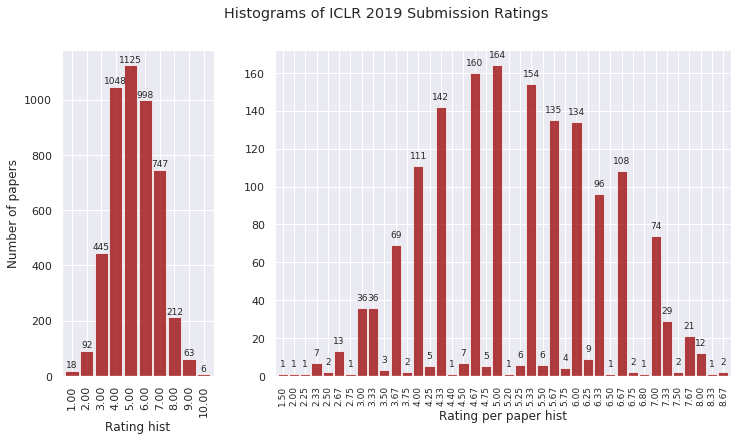

In [5]:
# Plot histograms of ratings
from collections import Counter
from matplotlib import gridspec
import seaborn as sns; sns.set()
fig = plt.figure(figsize=(12, 6))
plt.suptitle('Histograms of ICLR 2019 Submission Ratings')

# Rating hist
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
counterlist =  sorted(Counter(rating).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax1.set_xlabel('Rating hist')
ax1.set_ylabel('Number of papers')
ax1.set_xticklabels(x_labels)

rects = ax1.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=9)

# Rating per paper hist
plt.subplot(gs[1])
counterlist =  sorted(Counter(rating_mean).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax2 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax2.set_xlabel('Rating per paper hist')
# ax2.set_ylabel('Number of papers')
ax2.set_xticklabels(x_labels, fontsize=9)

rects = ax2.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 3, label,
            ha='center', va='bottom', fontsize=9)
plt.show()

In [6]:
# See how many papers are beaten by yours
def PR(rating_mean, your_rating):
    pr = np.sum(your_rating >= np.array(rating_mean))/len(rating_mean)*100
    return pr
my_rating = (6+6+6)/3  # your average rating here
print('Your papar ({:.2f}) beats {:.2f}% of submission '
      '(well, jsut based on the ratings...)'.format(
          my_rating, PR(rating_mean, my_rating)))


# ICLR 2017: accept rate 39.1% (198/507) (15 orals and 183 posters)
# ICLR 2018: accept rate 32% (314/981) (23 orals and 291 posters)
# ICLR 2018: accept rate ?% (?/1580)

Your papar (6.00) beats 77.12% of submission (well, jsut based on the ratings...)


In [7]:
# Count keywords
keywords_hist = Counter(keywords)
del keywords_hist['']
print('{} different keywords before merging'.format(len(keywords_hist)))

# Merge duplicates: CNNs and CNN
duplicates = []
for k in keywords_hist:
    if k+'s' in keywords_hist:
        duplicates.append(k)
for k in duplicates:
    keywords_hist[k] += keywords_hist[k+'s']
    del keywords_hist[k+'s']
# print('Merge: {}'.format([d+'s' for d in duplicates]))
print('{} different keywords after merging'.format(len(keywords_hist)))

2886 different keywords before merging
2783 different keywords after merging


In [8]:
# Create keywords list
keywords_list = []
keywords_key_list = []
for m in meta_list:
    for k in [mk for mk in m.keyword if not mk == '']:
        if k not in keywords_hist.keys():
            k = k[:-1]  # strip 's'
        if k in keywords_key_list:
            idx = keywords_key_list.index(k)
            keywords_list[idx].update_frequency(1)
            keywords_list[idx].update_rating(m.rating)
        else:
            # the keyword is new to the list
            k_object = Keyword(k, 1, m.rating)
            keywords_list.append(k_object)
            keywords_key_list.append(k_object.keyword)

67


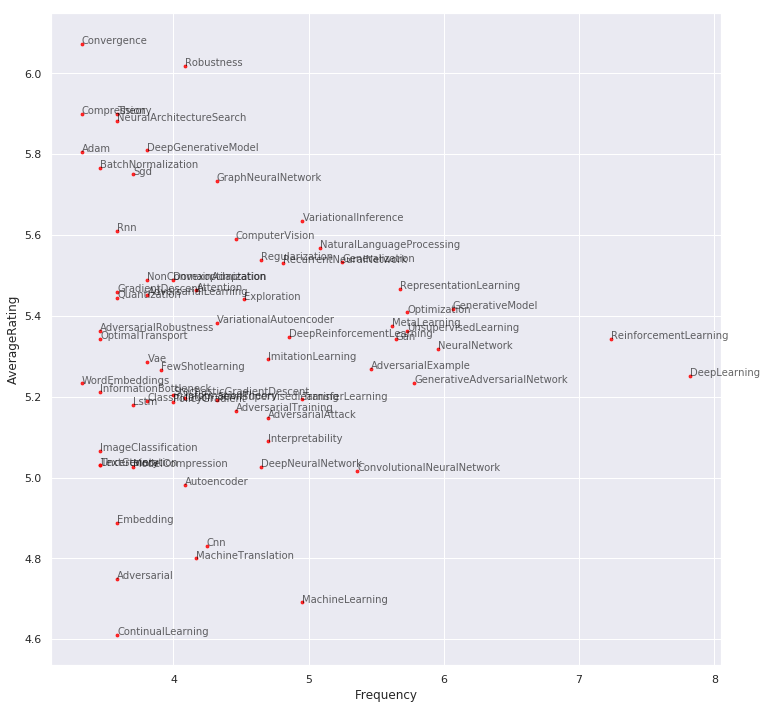

In [9]:
keywords_list_subset = [k for k in keywords_list if k.frequency > 9]
print(len(keywords_list_subset))
y = [k.average_rating() for k in keywords_list_subset]
x = [np.log2(k.frequency) for k in keywords_list_subset]
key = [k.keyword for k in keywords_list_subset]

# Create dataframe
df = pd.DataFrame({
    'Frequency': x,
    'AverageRating': y,
    'Keyword': key
})

sns.set(font_scale=1)
fig = plt.figure(figsize=(12, 12))
p1 = sns.regplot(data=df, x="Frequency", y="AverageRating", fit_reg=False, 
                 marker="o", color="red", logx=True, scatter_kws={'s': 8})
for line in range(0, df.shape[0]):
     p1.text(df.Frequency[line], df.AverageRating[line], df.Keyword[line], 
             horizontalalignment='left', 
             size='small', color='black', alpha=0.6)
plt.show()

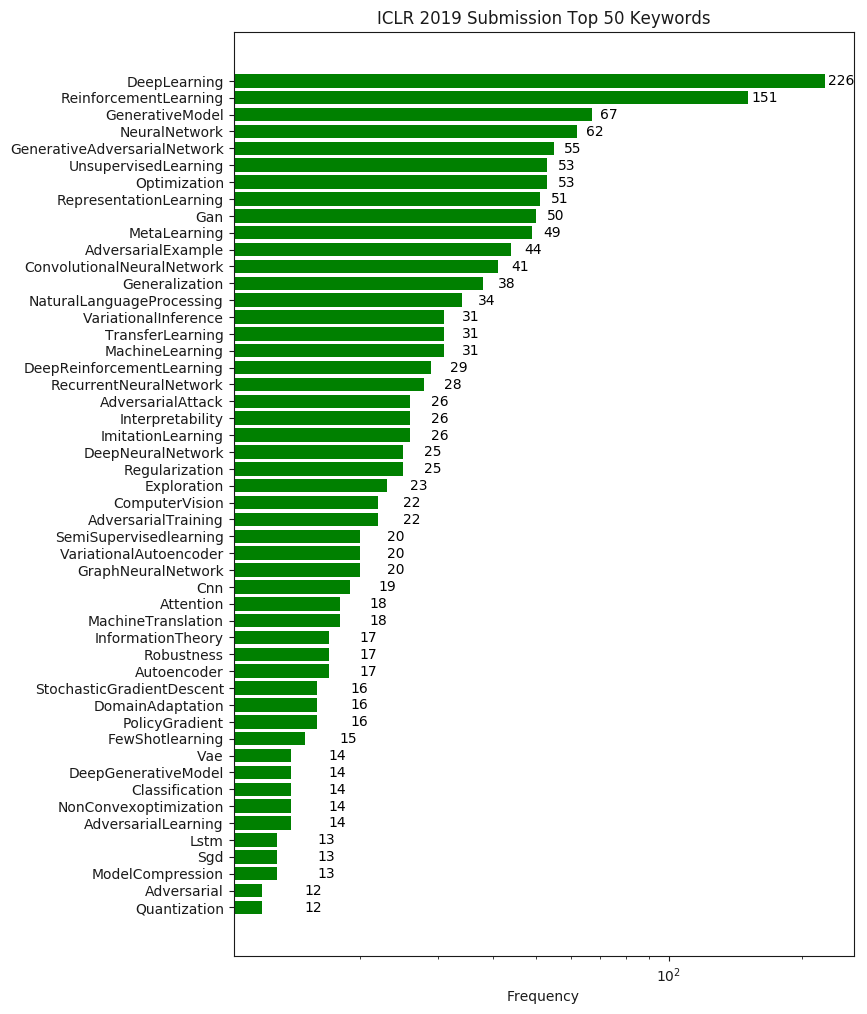

In [10]:
# Show N most common keywords and their frequencies
num_keyowrd = 50
keywords_hist_vis = keywords_hist.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

key = [k[0] for k in keywords_hist_vis] 
value = [k[1] for k in keywords_hist_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('ICLR 2019 Submission Top {} Keywords'.format(num_keyowrd))

plt.show()

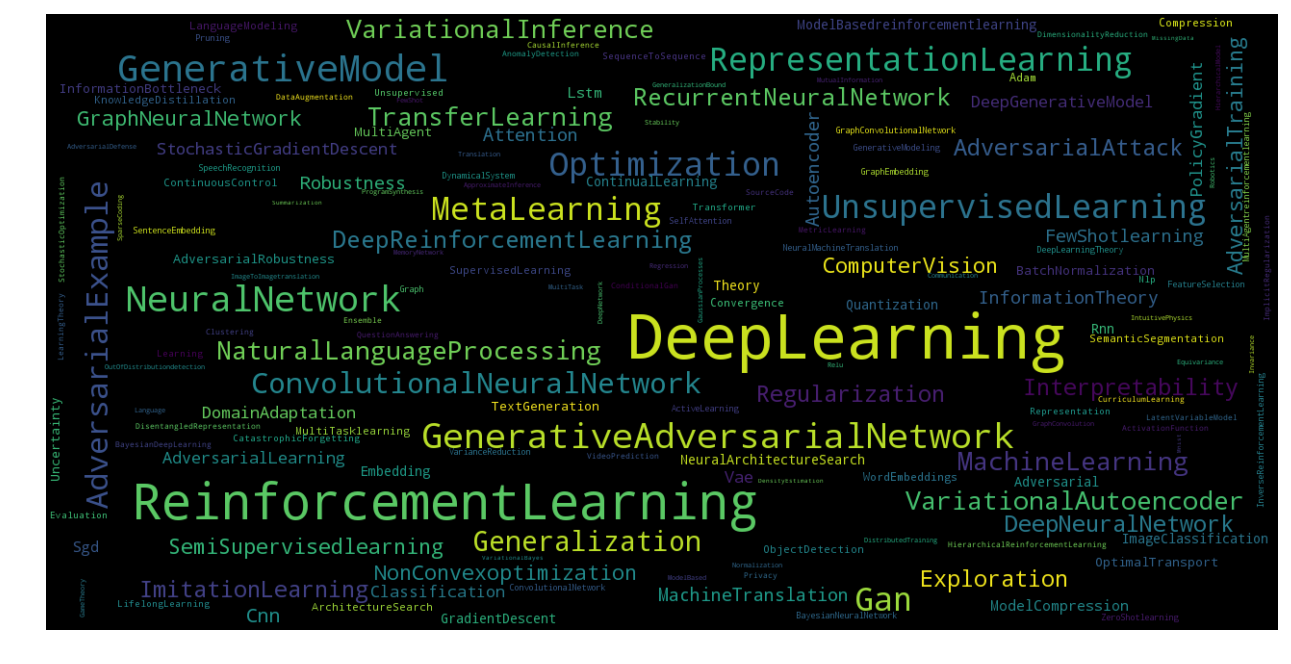

In [11]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(keywords))
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

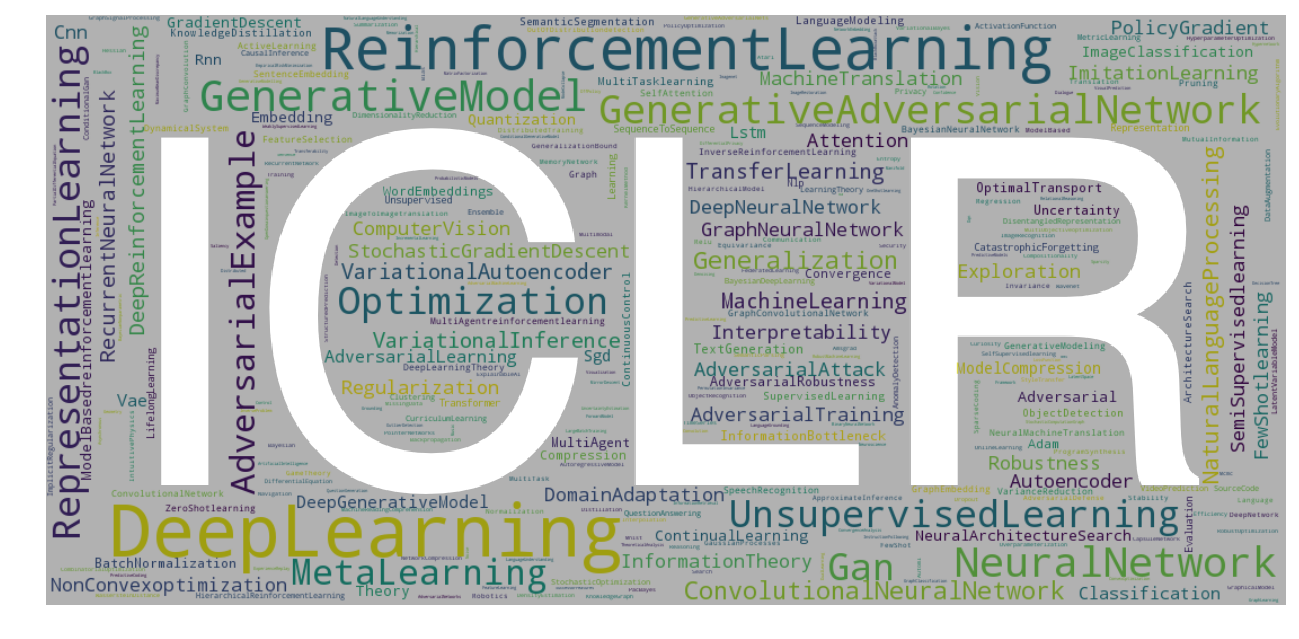

In [12]:
# Show the word cloud with an ICLR logo
from imageio import imread
logo = imread('asset/logo.png')
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white", mask=logo).generate(' '.join(keywords))
plt.figure(figsize=(16, 8), frameon=False)
plt.imshow(logo)
plt.imshow(wordcloud, interpolation="bilinear",  alpha=.7)
plt.axis("off")
plt.show()

In [13]:
num_valid = len(meta_list) - num_withdrawn
num_missing_rating = num_valid*3 - np.sum(np.clip(num_rating, 0, 3))
print('Number of missing reviews: {} ({:.4f}%)'.format(
    num_missing_rating, 100*float(num_missing_rating)/(num_valid*3)))

Number of missing reviews: 6 (0.1386%)


In [14]:
# the papers that don't have 3 reviews
for m in meta_list:
    if len(m.rating) < 3 and not m.withdrawn:
        print(m.title, m.url, m.rating)

Improving On-policy Learning With Statistical Reward Accumulation https://openreview.net/forum?id=HJgZrsC5t7 [4, 5]
Fast Exploration With Simplified Models And Approximately Optimistic Planning In Model Based Reinforcement Learning https://openreview.net/forum?id=HygS7n0cFQ [5, 4]
Fast Binary Functional Search On Graph https://openreview.net/forum?id=Bkg5aoAqKm [4, 5]
A Solution To China Competitive Poker Using Deep Learning https://openreview.net/forum?id=rJzoujRct7 [3, 2]
Peernets: Exploiting Peer Wisdom Against Adversarial Attacks https://openreview.net/forum?id=Sk4jFoA9K7 [7, 5]
S-system, Geometry, Learning, And Optimization: A Theory Of Neural Networks https://openreview.net/forum?id=HyxUIj09KX [4, 4]


In [15]:
# Write all the data to README
import datetime
with open('README.md', 'r+') as readme:
    lines = readme.readlines()

data_title = '## <a id="Data"></a>All ICLR 2019 OpenReview data\n'
idx = lines.index(data_title)
lines = lines[:idx]

with open('README.md', 'w') as readme:
    for line in lines:
        readme.write(line)
    readme.write(data_title)
    readme.write('Collected at {}\n\n'.format(datetime.datetime.now()))
    readme.write('| Rank | Average Rating | Title | Ratings | Variance | \n')
    readme.write('| --- | --- | --- | --- | --- | \n')
    non_empty_rating_meta_list = [m for m in meta_list if not len(m.rating)==0]
    empty_rating_meta_list = [m for m in meta_list if len(m.rating)==0]    
    sorted_idx = np.argsort([np.mean(m.rating) for m in non_empty_rating_meta_list])[::-1]
    for i, idx in enumerate(sorted_idx):
        m = non_empty_rating_meta_list[idx]
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} |\n'.format(
            i+1, np.mean(m.rating), 
            m.title if not m.withdrawn else '~~'+m.title+'~~',  
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating)
        ))
    for i, m in enumerate(empty_rating_meta_list):
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} |\n'.format(
            i+1+len(non_empty_rating_meta_list), np.mean(m.rating), 
            m.title if not m.withdrawn else '~~'+m.title+'~~',
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating)
        ))

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
